<a href="https://colab.research.google.com/github/RKAdEXED/Deep-Learning-a-gyarkolatban---BitMesterek/blob/main/Final_BitMesterek_Optiver_Trading_at_the_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import os
import zipfile
import numpy as np
import random
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# Mount drive to colab
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Navigate to working directory
# Change to your own Drive directory after MyDrive/

#%cd /content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi/

# Telling Kaggle where to find the API key, needed for dowloading dataset, change to your own directory after MyDrive/
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi"

In [4]:
# Commented out so Colab won't download each time when all cells are run

# Download data from Kaggle
#!kaggle competitions download -c optiver-trading-at-the-close

In [5]:
# Commented out so Colab won't download each time when all cells are run
# Unzip, then delete file


#for file in os.listdir():
 #   if file.endswith(".zip"):
  #      with zipfile.ZipFile(file, "r") as zip_file:
   #         zip_file.extractall()


# List files in working directory
%ls

sample_data/


In [6]:
# Download train.csv
!wget https://www.dropbox.com/scl/fi/ibujwdcz78j7u2svlqmum/train.csv?rlkey=r7rwxzxrawaavj8uyhb4edx6j&dl=0

--2023-12-12 16:39:55--  https://www.dropbox.com/scl/fi/ibujwdcz78j7u2svlqmum/train.csv?rlkey=r7rwxzxrawaavj8uyhb4edx6j
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7b272857521cf11e9de7465d70.dl.dropboxusercontent.com/cd/0/inline/CJSP0AU9XczBGIzI4vFWwjhi_Kzz4_-_dirFUqnzLeh6mdyopU0IW6n6Js3rrYjQiLu5g8xIB-fItrnc7iaXBuHNFC6fkrxddorhbqa1vTXg0OCHp9xSESuGnfTlm_4CbjCWsN_Ek3JokfrMhT5nHe_Z/file# [following]
--2023-12-12 16:39:56--  https://uc7b272857521cf11e9de7465d70.dl.dropboxusercontent.com/cd/0/inline/CJSP0AU9XczBGIzI4vFWwjhi_Kzz4_-_dirFUqnzLeh6mdyopU0IW6n6Js3rrYjQiLu5g8xIB-fItrnc7iaXBuHNFC6fkrxddorhbqa1vTXg0OCHp9xSESuGnfTlm_4CbjCWsN_Ek3JokfrMhT5nHe_Z/file
Resolving uc7b272857521cf11e9de7465d70.dl.dropboxusercontent.com (uc7b272857521cf11e9de7465d70.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:

In [7]:

import_data = pd.read_csv ('train.csv?rlkey=r7rwxzxrawaavj8uyhb4edx6j')
import_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


Number of datapoints:

200 stocks
481 days
55 steps each day

So number of datapoints should be 200 * 481 * 55  (stocks * days * steps) = 5291000

In [8]:

import_data.shape

(5237980, 17)

We can see that 53020 datapoints are missing

In [9]:

data_frame = import_data

# Group the data by 'date_id' and count the unique 'stock_id' values for each day
stock_count_per_day = data_frame.groupby('date_id')['stock_id'].nunique()

# Expected number of stocks each day
expected_stock_count = 200

# Number of missing stocks each day
missing_stock_count = expected_stock_count - stock_count_per_day

# Total missing stocks througouth the 200 days
total_missing_stocks = missing_stock_count.sum()

# Days and number of missing stocks
print("Date and number of missing stocks:")
print(missing_stock_count)

# Total number of missing stocks
print("Total number of missing stocks:", total_missing_stocks)


Date and number of missing stocks:
date_id
0      9
1      9
2      9
3      9
4      8
      ..
476    0
477    0
478    0
479    0
480    0
Name: stock_id, Length: 481, dtype: int64
Total number of missing stocks: 964


As we can see throughout the 481 days a total of 964 stocks are missing entirely. 964 * 55 = 53020,  so this means that missing data is found. This also means that fortunately that the stock data that we do have doesn't have any missing values.

In [10]:

# Function to plot the time series of a stock on a day
def stock_plotter(data_frame, cols, stock_id, date_id):

  # Filtering data_frame where the stock_id and date_id match with our inputs
  data_frame = data_frame.query(f'stock_id == {stock_id} & date_id == {date_id}')

  # We want all rows of the seconds_in_bucket and input columns
  data_frame = data_frame.loc[:, ['seconds_in_bucket'] + cols]

  # Set seconds_in_bucket as the index for the data_frame
  data_frame = data_frame.set_index('seconds_in_bucket')

  # Plot time series
  data_frame = data_frame.plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)

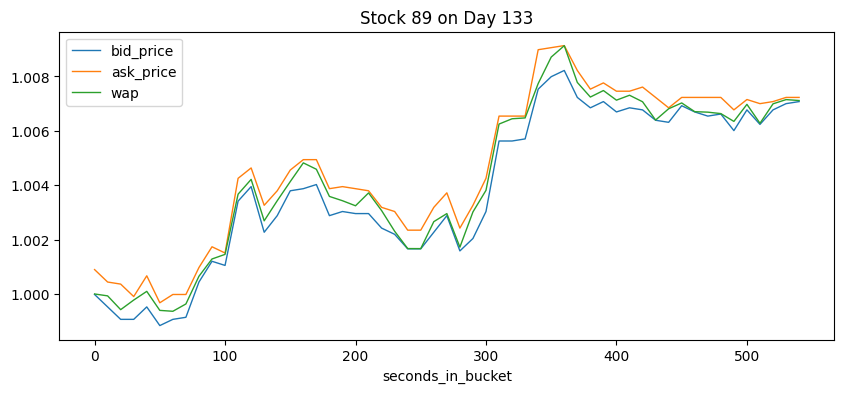

In [11]:

# Generate random numbers to print random stocks on random days, not excluding the missing ones (will have to fix in future)
stock_no = random.randint(0,200)
day_no = random.randint(0,481)

# Plot
stock_plotter(
  data_frame=import_data,
  cols=['bid_price','ask_price', 'wap'],
  stock_id=stock_no,
  date_id=day_no)



In [12]:


# Dropping NaN values because they cause errors in calculatin MAE
data_frame = data_frame.dropna(subset=['target'])

# Splitting data, dropping row_id becaues it's not necesseary, and it's 'object' type causing error with pandas
#X = data_frame.drop(['target', 'row_id'], axis=1)
#y = data_frame[['target']]


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,)


In [13]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [14]:

#There are a lot of Nan values in the dataset (especially in far_price, near_price), which causes problems with the training
print(data_frame.isnull().sum())


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
dtype: int64


In [15]:
#delete the rows where these features are NaN (only 132 each which is not a big loss, considering that the number of all rows are 2894254)
data_frame = data_frame.dropna(subset=['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap'])

In [16]:
!pip install xgboost

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def predict_missing_values(data_frame, target_column):
    # Filter out non-numeric columns
    numeric_df = data_frame.select_dtypes(include=['int', 'float', 'bool'])

    # Split the data into subsets
    data_with_target = numeric_df[numeric_df[target_column].notnull()]
    data_without_target = numeric_df[numeric_df[target_column].isnull()]

    # Prepare feature matrix (X) and target vector (y)
    X = data_with_target.drop(columns=[target_column])
    y = data_with_target[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {target_column}: {mse}")

    # Predict missing values
    X_missing = data_without_target.drop(columns=[target_column])
    predicted_values = model.predict(X_missing)

    # Fill in the missing values in the original DataFrame
    data_frame.loc[data_frame[target_column].isnull(), target_column] = predicted_values

# Predict and impute missing values
predict_missing_values(data_frame, 'far_price')
predict_missing_values(data_frame, 'near_price')

# Check remaining missing values
print(data_frame.isnull().sum())

Mean Squared Error for far_price: 0.4546290234381314
Mean Squared Error for near_price: 1.8573832448109786e-05
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64


In [18]:
# Splitting data, dropping row_id becaues it's not necesseary, and it's 'object' type causing error with pandas
X = data_frame.drop(['target', 'row_id'], axis=1)
y = data_frame[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import Hyperband

import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

#predicting with Hyperband

def build_model(hp):
    model_new = keras.Sequential()

     # Input layer
    model_new.add(layers.Flatten(input_shape=(X_train.shape[1],)))

    # Hidden layers
    for i in range(hp.Int('num_layers', min_value=2, max_value=4, step=1)):
        model_new.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model_new.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model_new.add(layers.Dense(1, activation='linear'))


    '''model_new.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    '''

    model_new.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error'])
    return model_new


input_shape = X_train.shape[1]
output_classes = 1

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner = Hyperband(
    build_model,
    #ideally it should be 1<maX but it is rather time consuming
    max_epochs=1,
    factor=3,
    objective='val_mean_absolute_error',
    directory='tuning_directory',
    project_name='project'
)

tuner.search(X_train, y_train, epochs = 1, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 1 Complete [00h 06m 29s]
val_mean_absolute_error: 6.403029441833496

Best val_mean_absolute_error So Far: 6.403029441833496
Total elapsed time: 00h 06m 29s


In [20]:

best_model = tuner.get_best_models(num_models=1)[0]

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    return mean_absolute_error(y_test, predictions)


# Evaluate the manually built and trained model
best_model_mae = evaluate_model(best_model, X_test, y_test)

32736/32736 [==============================] - 58s 2ms/step


In [21]:
# Load the existing best model if it exists
model_file = 'best_model.h5'
if os.path.exists(model_file):
    saved_model = load_model(model_file)
    saved_model_mae = evaluate_model(saved_model, X_test, y_test)
else:
    saved_model_mae = float('inf')  # Set to infinity if no model is saved

In [22]:
# Save the new model only if it performs better
if best_model_mae < saved_model_mae:
    best_model.save(model_file)
    print("New model saved as it performs better.")
else:
    print("Existing model retained as it performs better.")
    best_model = saved_model if os.path.exists(model_file) else new_model
    best_model_mae = saved_model_mae if os.path.exists(model_file) else new_model_mae

# Print out the overall best model's performance
print("Overall Best Model MAE:", best_model_mae)

New model saved as it performs better.
Overall Best Model MAE: 6.396562455377008


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
best_model.fit(X_train, y_train)

# Get predictions of test set
pred_LGB=best_model.predict(X_test)

# Calculate the mean absolute error of the predictions and target
mean_ae = mean_absolute_error(y_test,pred_LGB)
print("MAE score of model =", mean_ae)

32736/32736 [==============================] - 60s 2ms/step
MAE score of model = 6.3965049882391485
